## Create MAG accumulation curve
- How many new genomes do we assemble each metaG?
- Both strain and species wise
- Do we saturate the curve?

In [1]:
# import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/var/folders/b5/q0xwwzss4dd82xbt_8lh5qph0000gn/T/ipykernel_90603/2330492088.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# open clustering info
df = pd.read_csv('../data/Cdb_drep99.csv')

# keep from each genome SRA number
df['acc'] = df['genome'].str.split('_').str[1]
df['genome'] = df['genome'].str.split('.fasta').str[0]



In [3]:
# open clustering info
df2 = pd.read_csv('../data/Cdb_drep95.csv')

# keep from each genome SRA number
df2['acc'] = df['genome'].str.split('_').str[1]
df2['genome'] = df['genome'].str.split('.fasta').str[0]

In [4]:
df = df2

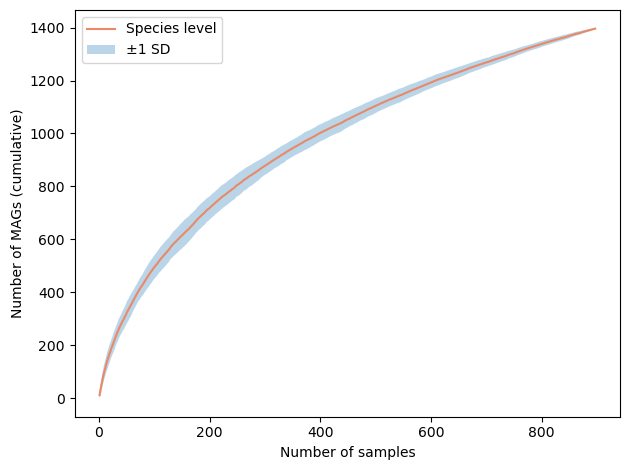

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def species_accumulation_from_long(df, sample_col='acc', species_col='secondary_cluster', n_permutations=100):
    samples = df[sample_col].unique()
    n_samples = len(samples)
    accumulation = np.zeros((n_permutations, n_samples))

    for i in range(n_permutations):
        np.random.seed(i)
        permuted_samples = np.random.permutation(samples)
        observed_species = set()
        for j, sample in enumerate(permuted_samples):
            species_in_sample = df[df[sample_col] == sample][species_col].unique()
            observed_species.update(species_in_sample)
            accumulation[i, j] = len(observed_species)

    mean_accumulation = accumulation.mean(axis=0)
    std_accumulation = accumulation.std(axis=0)
    return mean_accumulation, std_accumulation

# Example usage:
# df = your DataFrame with 'acc' and 'secondary_cluster' columns
mean, std = species_accumulation_from_long(df)

# Plot
x = np.arange(1, len(mean) + 1)
plt.plot(x, mean, label='Species level', color='#e98967ff')
plt.fill_between(x, mean - std, mean + std, alpha=0.3, label='±1 SD')
plt.xlabel('Number of samples')
plt.ylabel('Number of MAGs (cumulative)')
#plt.title('Species Accumulation Curve')
plt.legend()
plt.tight_layout()
#plt.savefig("../plots/250722_accumulation_curve_species.pdf", bbox_inches='tight')

plt.show()


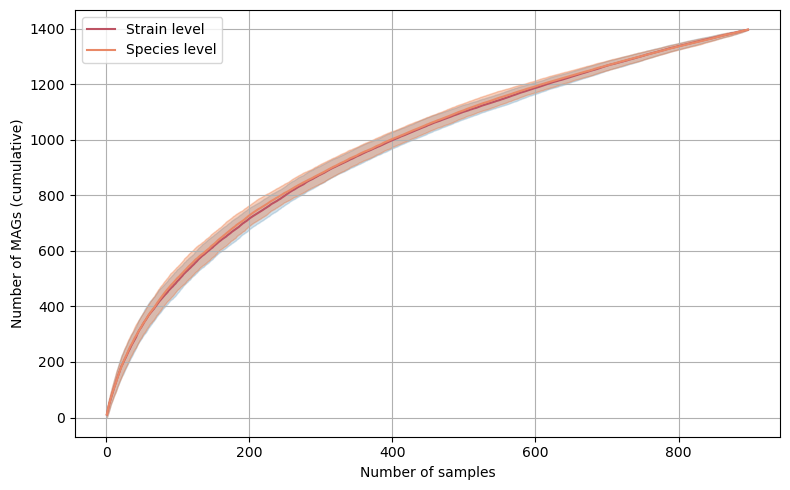

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_accumulation(df, sample_col='acc', cluster_col='secondary_cluster', n_permutations=100):
    max_samples = df[sample_col].nunique()
    accumulated = np.zeros((n_permutations, max_samples))
    unique_accs = df[sample_col].unique()

    for i in range(n_permutations):
        seen = set()
        sample_order = np.random.permutation(unique_accs)
        counts = []
        for j, acc in enumerate(sample_order):
            clusters = df[df[sample_col] == acc][cluster_col].unique()
            seen.update(clusters)
            counts.append(len(seen))
        accumulated[i, :] = counts

    mean_curve = accumulated.mean(axis=0)
    std_curve = accumulated.std(axis=0)
    return mean_curve, std_curve

# Compute both curves
mean1, std1 = compute_accumulation(df)
mean2, std2 = compute_accumulation(df2)

# Shared x-axis range (trim to shortest if needed)
max_len = min(len(mean1), len(mean2))
x = np.arange(1, max_len + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, mean1[:max_len], label='Strain level', color='#bd5363ff')
plt.fill_between(x, mean1[:max_len] - std1[:max_len], mean1[:max_len] + std1[:max_len], color='#669bbc', alpha=0.3)

plt.plot(x, mean2[:max_len], label='Species level', color='#e98967ff')
plt.fill_between(x, mean2[:max_len] - std2[:max_len], mean2[:max_len] + std2[:max_len], color='#eb6424', alpha=0.3)

plt.xlabel('Number of samples')
plt.ylabel('Number of MAGs (cumulative)')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("../plots/250722_accumulation_curve_comparison_overlay.pdf", bbox_inches='tight')
plt.show()


##  Do we want an accumulation curve for samples?
- How many new species do we recover in each sample? Using all the MAGs, and GTDB? 
- Using all MAGs would be like using all genomes.. 

In [8]:
# open df with pres/abs
# df = pd.read_csv('../sourmash_gather/250721_gatherout.pig.csv', index_col=0)
df1 = pd.read_csv('../data/250830_gatherout.gtdbmags.species.pig.csv', index_col=0)
df1 = df1[df1.sum(axis=1) != 0]

# make bool
#df1 = df1.astype(bool) 
len(df1)

56739

In [14]:
df2 = pd.read_csv('../data/250813_gatherout.gtdb.species.pig.csv', index_col=0)
df2 = df2[df2.sum(axis=1) != 0]

# make bool
df2 = df2.astype(bool) 
len(df2)

55780

In [15]:
# set num perm
n_permutations = 100


In [20]:
#store accum species counts for eaach permutation
accumulated_counts = np.zeros((n_permutations, df.shape[1]))


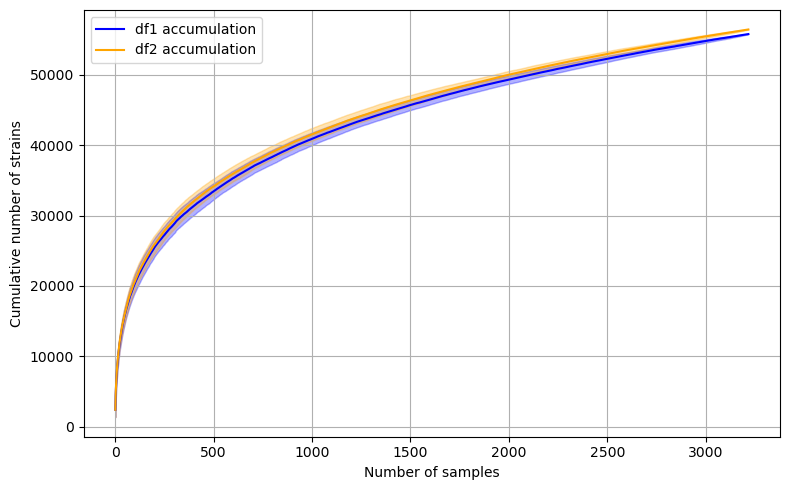

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def accumulation_curve(df, n_permutations=100):
    accumulated_counts = np.zeros((n_permutations, df.shape[1]))

    for i in range(n_permutations):
        permuted_cols = np.random.permutation(df.columns)
        seen_species = np.zeros(df.shape[0], dtype=bool)
        species_counts = []

        for col in permuted_cols:
            seen_species |= df[col].values
            species_counts.append(seen_species.sum())

        accumulated_counts[i, :] = species_counts

    mean_accum = accumulated_counts.mean(axis=0)
    std_accum = accumulated_counts.std(axis=0)
    return mean_accum, std_accum

# Compute accumulation curves for both dataframes
mean1, std1 = accumulation_curve(df1)
mean2, std2 = accumulation_curve(df2)

# Plot both curves
plt.figure(figsize=(8,5))

# df1 curve
plt.plot(range(1, df1.shape[1]+1), mean1, label='df1 accumulation', color='blue')
plt.fill_between(range(1, df1.shape[1]+1), mean1-std1, mean1+std1, color='blue', alpha=0.3)

# df2 curve
plt.plot(range(1, df2.shape[1]+1), mean2, label='df2 accumulation', color='orange')
plt.fill_between(range(1, df2.shape[1]+1), mean2-std2, mean2+std2, color='orange', alpha=0.3)

plt.xlabel("Number of samples")
plt.ylabel("Cumulative number of strains")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../plots/250813_accumulation_curve_samples_comparison.pdf", bbox_inches='tight')
plt.show()


## Kmer accumulation curve
How many new kmers with each assembled MAG?

In [5]:
# open clustering info
df2 = pd.read_csv('../data/Cdb_drep95.csv')

# keep from each genome SRA number
df2['acc'] = df2['genome'].str.split('_').str[1]
df2['genome'] = df2['genome'].str.split('.fasta').str[0]

In [6]:
sample_species = df2.groupby("acc")["secondary_cluster"].unique().to_dict()
mean_curve, std_curve = species_accumulation(sample_species)

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("../data/new_kmers_mags.k31.csv")
 
df = df.sort_values(by=["iteration", "position"])

# Group by iteration and calculate cumulative kmers per sample position
df["cumulative"] = df.groupby("iteration")["new_kmers"].cumsum()

# Calculate mean and std across iterations at each sample position
summary = df.groupby("position")["cumulative"].agg(["mean", "std"]).reset_index()
summary

,position,mean,std
0,1,26572.59,25378.035201
1,2,52016.27,29612.891839
2,3,73610.38,36585.970023
3,4,93592.60,38359.600030
4,5,115867.10,41913.936755
...,...,...,...
892,893,985715.94,90.859178
893,894,985738.30,87.956314
894,895,985771.48,75.277330
895,896,985799.88,66.639128


In [4]:
def species_accumulation(sample_species, n_iter=300):
    samples = list(sample_species.keys())
    n_samples = len(samples)
    results = []

    for _ in range(n_iter):
        order = np.random.permutation(samples)
        seen = set()
        curve = []
        for i, s in enumerate(order, start=1):
            seen.update(sample_species[s])
            curve.append(len(seen))
        results.append(curve)

    results = np.array(results)
    return results.mean(axis=0), results.std(axis=0)

sample_species = df2.groupby("acc")["secondary_cluster"].unique().to_dict()
mean_curve, std_curve = species_accumulation(sample_species)

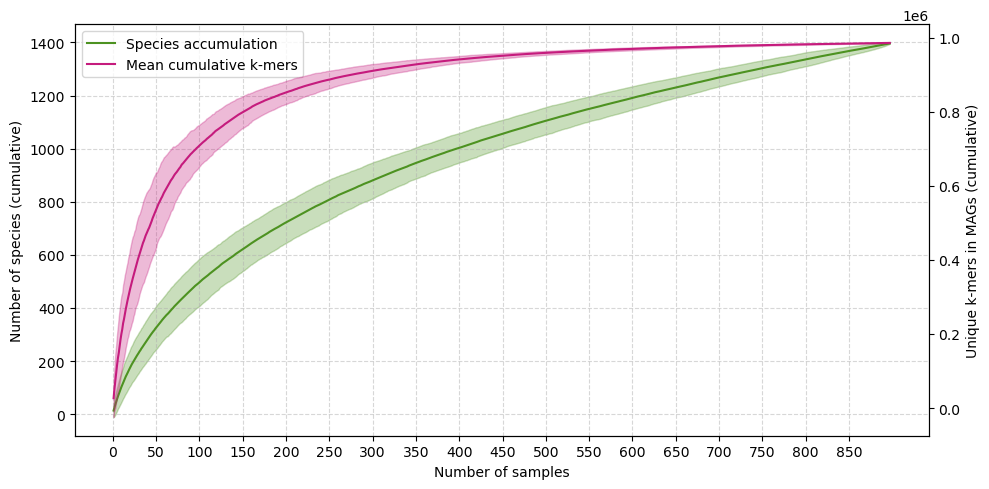

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- Species accumulation curve ---
x_species = np.arange(1, len(mean_curve)+1)

# --- K-mer curve ---
x_kmer = summary["position"]
mean_kmer = summary["mean"]
std_kmer = summary["std"]

fig, ax1 = plt.subplots(figsize=(10,5))

# Left y-axis: species accumulation
ax1.plot(x_species, mean_curve, color="#4d9221", label="Species accumulation")
ax1.fill_between(x_species, mean_curve-2*std_curve, mean_curve+2*std_curve, alpha=0.3, color="#4d9221")
ax1.set_xlabel("Number of samples")
ax1.set_ylabel("Number of species (cumulative)")
ax1.grid(True, ls="--", alpha=0.5)

# Right y-axis: k-mer accumulation
ax2 = ax1.twinx()
ax2.plot(x_kmer, mean_kmer, color="#c51b7d", label="Mean cumulative k-mers")
ax2.fill_between(x_kmer, mean_kmer-2*std_kmer, mean_kmer+2*std_kmer, alpha=0.3, color="#c51b7d")
ax2.set_ylabel("Unique k-mers in MAGs (cumulative)")

# Optional: combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
plt.xticks(np.arange(0, len(mean_curve)+1, 50))
plt.tight_layout()
plt.savefig('../plots/250925_accumulation_kmervspecies.png')


In [9]:
# import pandas as pd
# import matplotlib.pyplot as plt



# # Make sure sorting is correct (just in case)
# df = df.sort_values(by=["iteration", "position"])

# # Group by iteration and calculate cumulative kmers per sample position
# df["cumulative"] = df.groupby("iteration")["new_kmers"].cumsum()

# # Calculate mean and std across iterations at each sample position
# summary = df.groupby("position")["cumulative"].agg(["mean", "std"]).reset_index()

# # Plot mean ± std accumulation curve
# plt.figure(figsize=(8, 5))
# plt.plot(summary["position"], summary["mean"], label="Mean cumulative k-mers")
# plt.fill_between(summary["position"],
#                  summary["mean"] - summary["std"],
#                  summary["mean"] + summary["std"],
#                  alpha=0.3, label="±1 std")

# plt.xlabel("Number of assembled samples (cumulative)")
# plt.ylabel("Unique kmers in MAGs (cumulative)")
# plt.ticklabel_format(style='plain', axis='y')
# #plt.yscale("log")
# #plt.title("Accumulation Curve of Unique k-mers (Resampled)")
# #plt.legend()
# plt.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.7)
# plt.tight_layout()
# #plt.show()
# #plt.savefig('../plots/250808_accumcurve_kmers.k31.pdf')